In [1]:
# Mount your google drive and make sure it has the following:
# 1) zipped malware dataset file
# 2) the data.py file
# 3) the 5 Opcode Dictionary JSON files (corresponding to each malware family)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Extract the authentic malware datasets
# This cell block of code was copied from Harshit Trehan
!cp /content/drive/MyDrive/CMPE_295/malware_data.zip .
!unzip malware_data.zip
!rm malware_data.zip
!rm -rf /content/__MACOSX

Streaming output truncated to the last 5000 lines.
  inflating: WinWebSec/fb1ef23c9dcb41e4e695b0f77006002e13397f1f.asm.txt  
  inflating: __MACOSX/WinWebSec/._fb1ef23c9dcb41e4e695b0f77006002e13397f1f.asm.txt  
  inflating: WinWebSec/fa8e99c81737f1a3f8d667bff7242f201e6b3ecb.asm.txt  
  inflating: __MACOSX/WinWebSec/._fa8e99c81737f1a3f8d667bff7242f201e6b3ecb.asm.txt  
  inflating: WinWebSec/1afc2a2036812279c58de0b825ebdea423341182.asm.txt  
  inflating: __MACOSX/WinWebSec/._1afc2a2036812279c58de0b825ebdea423341182.asm.txt  
  inflating: WinWebSec/535f05c124a21b5d1746ac7c1d36ed7df3eeb260.asm.txt  
  inflating: __MACOSX/WinWebSec/._535f05c124a21b5d1746ac7c1d36ed7df3eeb260.asm.txt  
  inflating: WinWebSec/b77d8d8fc75ecf193af4e90ab559bc54f2bd38b6.asm.txt  
  inflating: __MACOSX/WinWebSec/._b77d8d8fc75ecf193af4e90ab559bc54f2bd38b6.asm.txt  
  inflating: WinWebSec/008883bab2c8e1f32d03707abd5dc7650c813615.asm.txt  
  inflating: __MACOSX/WinWebSec/._008883bab2c8e1f32d03707abd5dc7650c813615.asm.t

In [3]:
# Load the data.py file and the 5 opdict JSON files
# This cell block of code was copied from Harshit Trehan

!cp /content/drive/MyDrive/CMPE_295/data.py .
!cp /content/drive/MyDrive/CMPE_295/opdictWinWebSec.json .
!cp /content/drive/MyDrive/CMPE_295/opdictZbot.json .
!cp /content/drive/MyDrive/CMPE_295/opdictVBInject.json .
!cp /content/drive/MyDrive/CMPE_295/opdictOnLineGames.json .
!cp /content/drive/MyDrive/CMPE_295/opdictRenos.json .
!cp /content/drive/MyDrive/CMPE_295/opdictAllFiveFamilies.json .

In [4]:
# only need this for testing out classifiers
# !mkdir /content/AllFiveFamilies
# !ln -s /content/OnLineGames/* /content/AllFiveFamilies
# !ln -s /content/Renos/* /content/AllFiveFamilies
# !ln -s /content/VBInject/* /content/AllFiveFamilies
# !ln -s /content/WinWebSec/* /content/AllFiveFamilies
# !ln -s /content/Zbot/* /content/AllFiveFamilies

In [5]:
# Import the basics
import os
import sys
import numpy as np
import glob
import json
import data
import math

# Import for plotting
import matplotlib.pyplot as plt

# Import tensorflow and keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from functools import partial
from tensorflow.keras.utils import plot_model

import keras.backend as K

# Import supporting libraries for training
from sklearn.model_selection import train_test_split

# Import the ML classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import libraries for DL classifiers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# Import libraries for final evaluation of the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score

# Fix random seed for reproducibility
tf.random.set_seed(7)

# Don't need these imports
# from keras.callbacks import Callback
# from keras.models import load_model
# from sklearn.preprocessing import normalize
# from tensorflow.keras.layers import BatchNormalization, Activation, LayerNormalization

In [6]:
# Run the data.py file to transform the first 600 opcode sequences in each malware file into a numerical representation.
# Note that qty of the first 600 opcode sequences was arbitrary.
# This cell block of code was copied from Harshit Trehan and then modified.

fam = 'WinWebSec' #'Zbot', 'VBInject', 'OnLineGames', 'Renos', 'WinWebSec', 'AllFiveFamilies'
max_sequence_length = 600

data_obj = data.DATA(fam, max_sequence_length)
data_samples, num_unique = data_obj.load_data(True)
print('Num unique: %d'%num_unique)
  

Total samples for WinWebSec: 4360
Mappings in JSON file: 21
Num unique: 21


In [7]:
# Normalize the dataset across each row
# nds is an abbreviation for "normalized data set"
nds = data_samples/num_unique
#nds = normalize(data_samples)
print("original numpy shape of data_samples:", data_samples.shape)
print("normalized numpy shape of nds:", nds.shape)

# Modify the shape of the input vector to match the format needed for Conv1D
nds = nds[..., None]
print("fixing the normalized numpy shape of nds for VAE:", nds.shape)

original numpy shape of data_samples: (3932, 600)
normalized numpy shape of nds: (3932, 600)
fixing the normalized numpy shape of nds for VAE: (3932, 600, 1)


In [8]:
# Creating a sampling layer (necessary for the "V" in the VAE)
# It's used at the end of the Encoder
# This cell block of code was copied from Keras documentation on VAE

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Build the Encoder
# This cell block of code was inspired by Keras documentation on VAE

# Define the number of latent dimensions you want
latent_dim = 2

# Define the stride size you want
s = 2

# Define the alpha of the LeakyReLU. Alpha is the negative slope of the coefficient (default is 0.3)
a = 0.01 #0.2

# Define the shape of the input layer to the Encoder
encoder_inputs = keras.Input(shape=nds[0].shape)

# Define the 1D CNN layers of the VAE Encoder
x = layers.Conv1D(64, 3, activation=LeakyReLU(alpha=a), strides=s, padding="same")(encoder_inputs)
x = layers.Conv1D(128, 3, activation=LeakyReLU(alpha=a), strides=s, padding="same")(x)
x = layers.Conv1D(256, 3, activation=LeakyReLU(alpha=a), strides=s, padding="same")(x)
x = layers.Conv1D(512, 3, activation=LeakyReLU(alpha=a), strides=3, padding="same")(x)

# Process the output of the 1D CNNs through a fully connected dense layer
x = layers.Flatten()(x)
x = layers.Dense(16, activation=LeakyReLU(alpha=a))(x)

# Calculate the mean, variance, and sampled latent variables at the end of the Encoder
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

# Define and summarize the Encoder model architecture
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 300, 64)      256         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 150, 128)     24704       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 75, 256)      98560       ['conv1d_1[0][0]']               
                                                                                            

In [10]:
# Build the Decoder
# This cell block of code was inspired by Keras documentation on VAE

# Define the shape of the input layer to the Decoder (it's the latent variables)
latent_inputs = keras.Input(shape=(latent_dim,))

# Define the stride size you want
sd = s

# Define the alpha of the LeakyReLU. Alpha is the negative slope of the coefficient (default is 0.3)
ad = a

# Grab the number of rows and channels from the last conv1D layer of the Encoder
rows = encoder.layers[4].output.shape[1]
channels = encoder.layers[4].output.shape[2]

# Calculate the number of attributes you want in your first flattened layer of the Decoder
flat_att = rows * channels

# Process the latent variable output of the Encoder through a fully connected dense layer as the first layer of the Decoder
x = layers.Dense(flat_att, activation=LeakyReLU(alpha=ad))(latent_inputs)

# Reshape your first dense layer and run it through layers of conv1DTranspose to complete the Decoder
x = layers.Reshape((rows, channels))(x)
x = layers.Conv1DTranspose(channels, 3, activation=LeakyReLU(alpha=ad), strides=3, padding="same")(x)
x = layers.Conv1DTranspose((channels/2), 3, activation=LeakyReLU(alpha=ad), strides=sd, padding="same")(x)
x = layers.Conv1DTranspose((channels/4), 3, activation=LeakyReLU(alpha=ad), strides=sd, padding="same")(x)
x = layers.Conv1DTranspose((channels/8), 3, activation=LeakyReLU(alpha=ad), strides=sd, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation=LeakyReLU(alpha=ad), padding="same")(x)

# Define and summarize the Decoder model architecture
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12800)             38400     
                                                                 
 reshape (Reshape)           (None, 25, 512)           0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 75, 512)          786944    
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 150, 256)         393472    
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 300, 128)         9843

In [11]:
# This code was copied from the Keras VAE tutorial and modified

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def train_step(self, data):    
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(data, training=True)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1)))
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

In [12]:
# Set up the variables for training the 1D CNN VAE on the predefined malware family
total_epochs = 100
lr = 0.001

# Train the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
history = vae.fit(nds, epochs=total_epochs)#, validation_split=0.2)


Epoch 1/100
123/123 [==============================] - 9s 46ms/step - loss: 368.5816 - reconstruction_loss: 306.9615 - kl_loss: 1.4793
Epoch 2/100
123/123 [==============================] - 5s 44ms/step - loss: 286.2615 - reconstruction_loss: 283.9073 - kl_loss: 2.0107
Epoch 3/100
123/123 [==============================] - 5s 44ms/step - loss: 284.0430 - reconstruction_loss: 281.1957 - kl_loss: 2.3996
Epoch 4/100
123/123 [==============================] - 5s 44ms/step - loss: 282.1944 - reconstruction_loss: 278.9845 - kl_loss: 2.7993
Epoch 5/100
123/123 [==============================] - 5s 43ms/step - loss: 280.8331 - reconstruction_loss: 277.0101 - kl_loss: 3.1031
Epoch 6/100
123/123 [==============================] - 5s 43ms/step - loss: 279.2229 - reconstruction_loss: 275.0627 - kl_loss: 3.3872
Epoch 7/100
123/123 [==============================] - 5s 42ms/step - loss: 276.7944 - reconstruction_loss: 273.0959 - kl_loss: 3.7388
Epoch 8/100
123/123 [==============================] - 

Saved loss chart


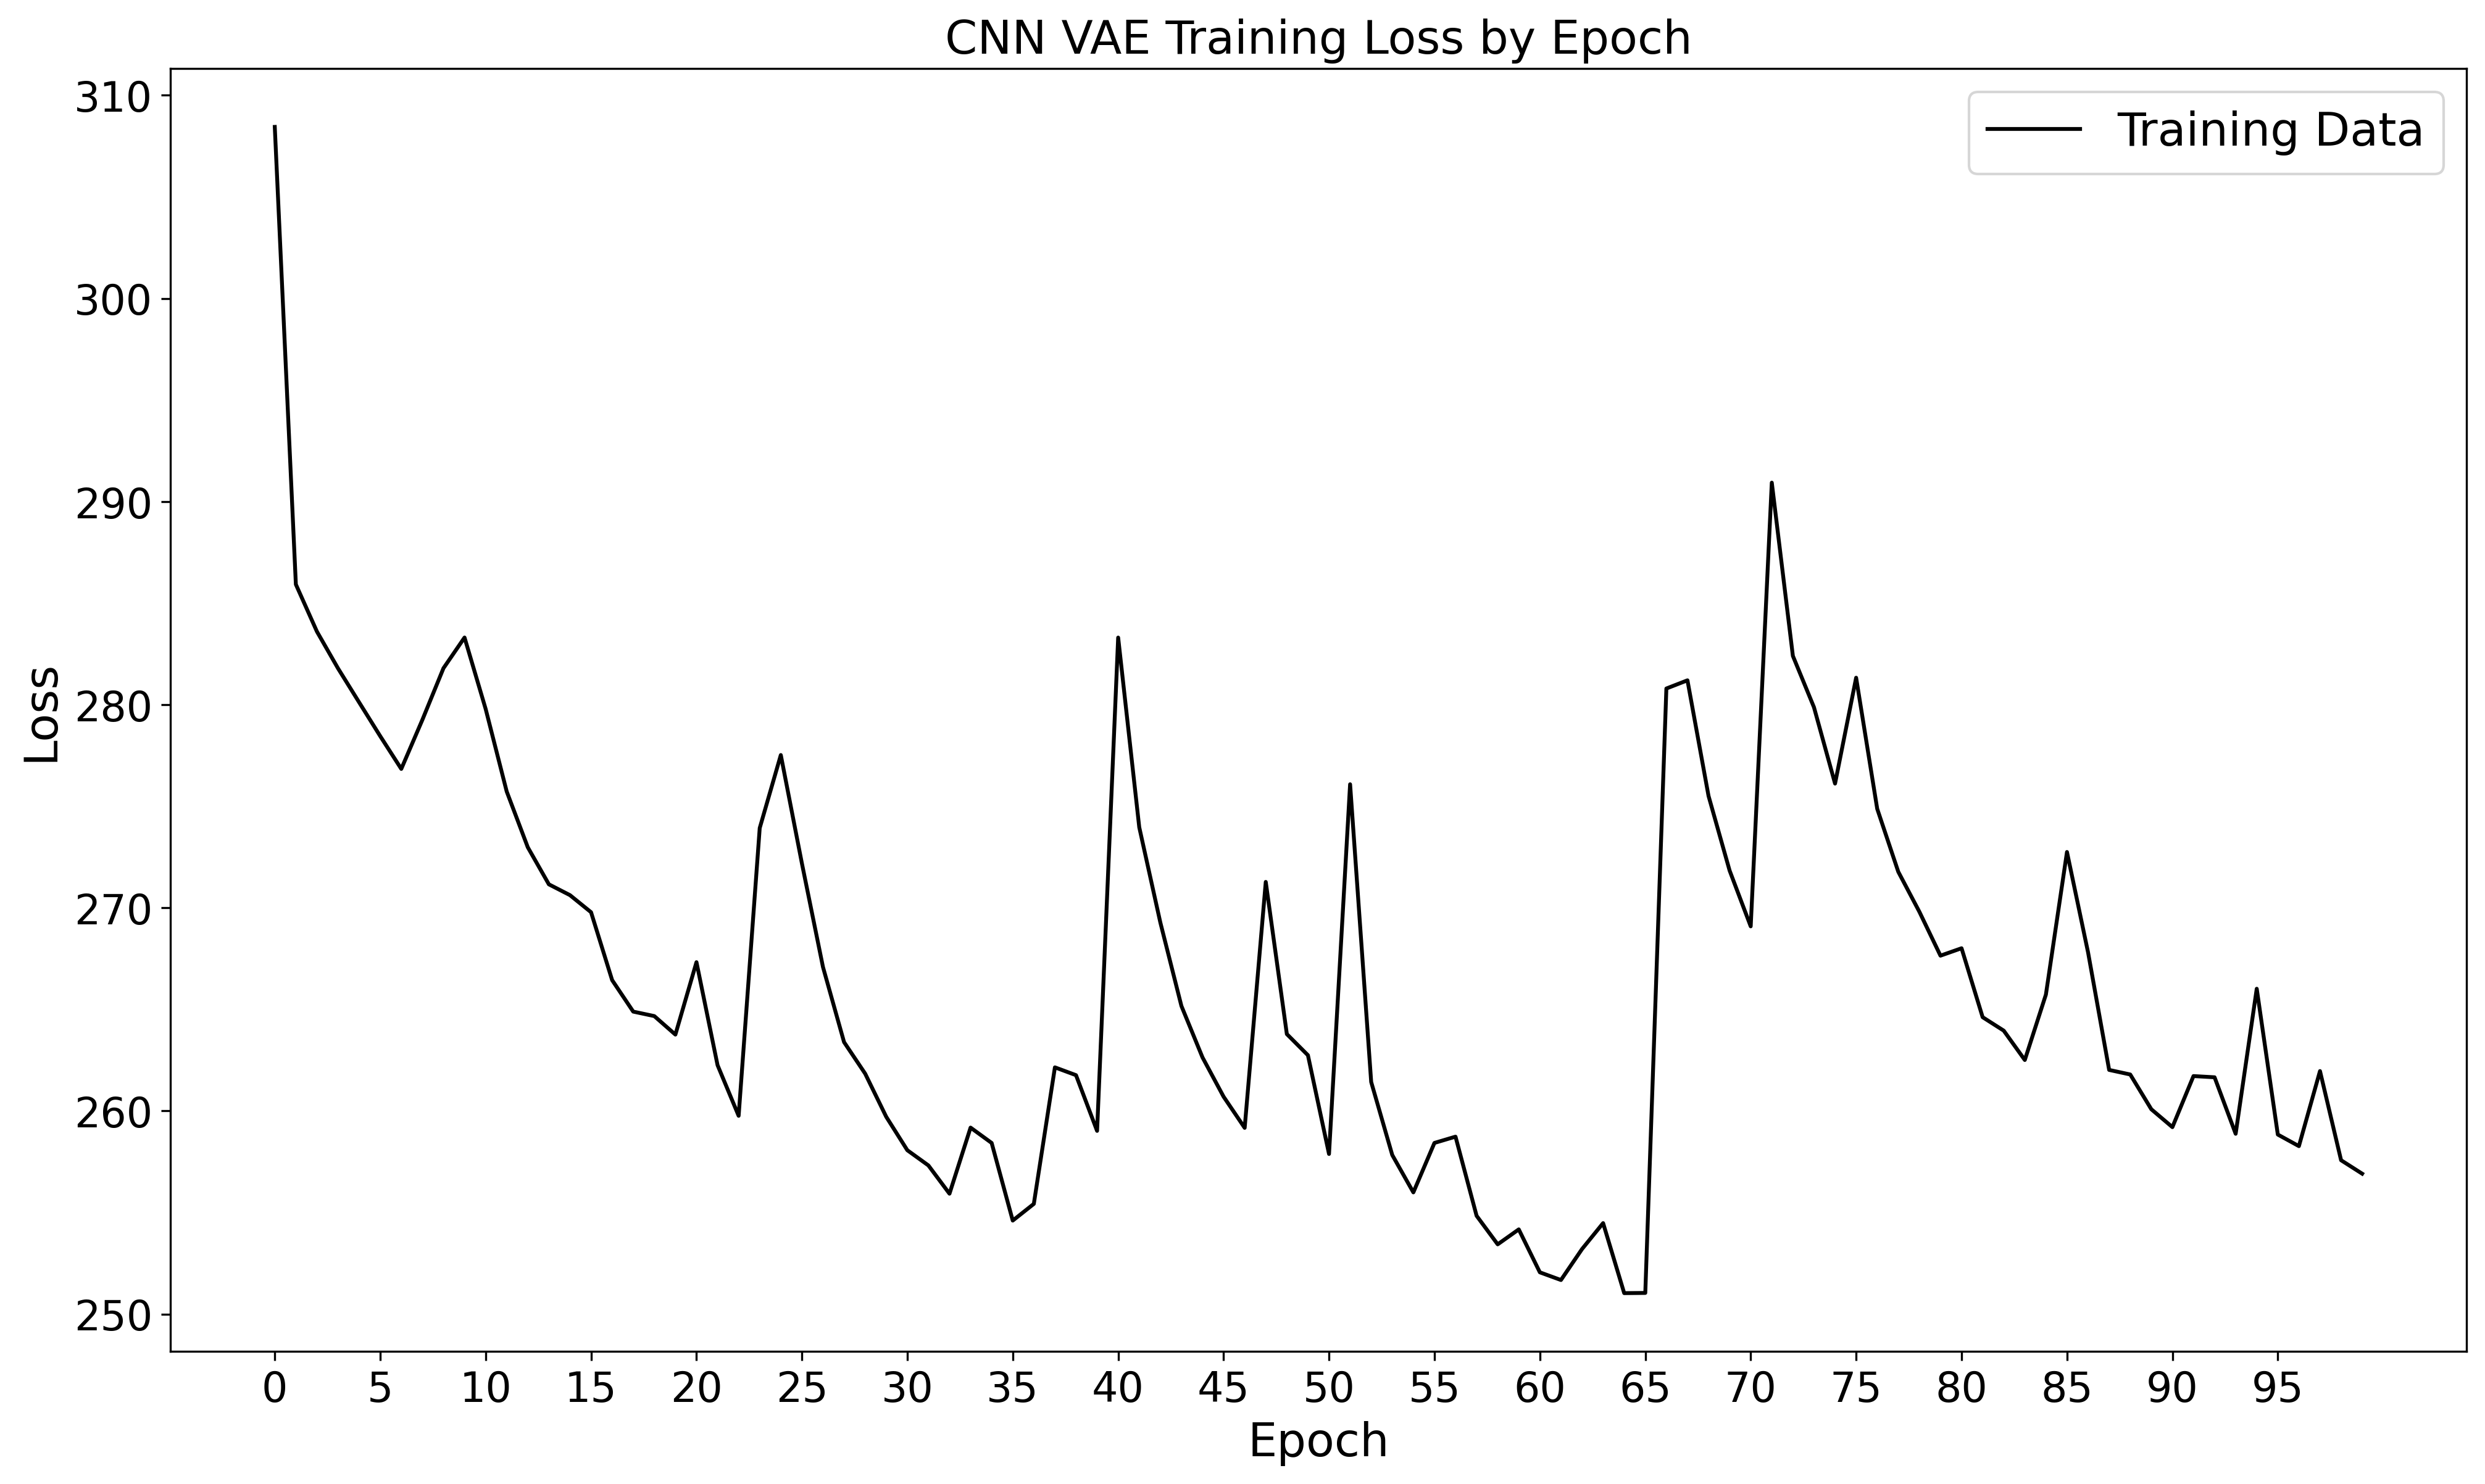

In [14]:
# Plot a loss chart
ls = 18
ss = 16
fs = 18
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='CNN VAE Training Loss by Epoch', loc='center', fontsize=ls)

ax.plot(history.history['loss'], label='Training Data', color='black')
# ax.plot(history_test.history['loss'], label='Validation Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.xaxis.get_label().set_fontsize(fs)
ax.yaxis.get_label().set_fontsize(fs)
plt.xticks(ticks=np.arange(len(history.history['loss']), step=5), labels=np.arange(0, len(history.history['loss']), step=5))
ax.tick_params(axis='both', which='major', labelsize=ss)
plt.legend(fontsize=fs)

# save loss chart
print('Saved loss chart')
# plt.savefig(fp+'my_loss_chart_'+real_malware+'.png')
plt.show()

In [ ]:
# Generate synthetic malware from the trained Decoder 
# num_samples = len(data_samples)

# noise = np.random.normal(0, 1, (num_samples, latent_dim))

# gen_samples = vae.decoder.predict(noise)
# gen_samples = np.reshape(gen_samples, (num_samples, max_sequence_length))
# gen_samples = gen_samples*num_unique
# gen_samples = np.rint(gen_samples)
# gen_samples = gen_samples.astype(int)
# gen_samples = np.clip(gen_samples, 0, num_unique)

# fname = "1DCNNVAE_" + str(fam) + "_" + str(channels) + "LV" + str(latent_dim)
# np.save(fname, gen_samples)